In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from tqdm import tqdm


import matplotlib.ticker as ticker

def plot_colourline(x,y,c, ax, **kwargs):
    for i in np.arange(len(x)-1):        
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=cmap((c[i]-vmin)/(vmax-vmin)), **kwargs)
    return ax

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Numerical evaluation of alignment conditions

In [72]:
import os
import pandas as pd
import numpy as np
from fixed_point_sol import *
from generate_data import ar1_cov
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
from joblib import Parallel, delayed

p = 500

cov = 'ar1'
rho_ar1 = 0.5
Sigma = ar1_cov(rho_ar1, p)

top_k = 1
_, beta0_1 = eigsh(Sigma, k=top_k, which='LM')
_, beta0_2 = eigsh(Sigma, k=top_k, which='SM')
beta0 = np.mean(beta0_1 + beta0_2, axis=-1)/2


print(beta0.T @ beta0)

0.49999999999997397


In [86]:
res = []
phi_list = [2,5,10]
lam_list = np.logspace(-6, 2, 100)
for phi in phi_list:
    for lam in lam_list:
        v = v_general(phi, lam, Sigma)
        # mu = 1/v
        # print(lam, mu)
        # b2 = np.trace(np.linalg.solve(mu**2*np.linalg.matrix_power(Sigma+mu*np.identity(p), 2), Sigma @ beta0[:,None] @ beta0[:,None].T))/p
        # b3 = np.trace(np.linalg.solve(mu**3*np.linalg.matrix_power(Sigma+mu*np.identity(p), 3), Sigma @ beta0[:,None] @ beta0[:,None].T))/p
        b2 = np.trace(np.linalg.solve(np.linalg.matrix_power(v*Sigma+np.identity(p), 2), Sigma @ beta0[:,None] @ beta0[:,None].T))/p
        b3 = np.trace(np.linalg.solve(np.linalg.matrix_power(v*Sigma+np.identity(p), 3), Sigma @ beta0[:,None] @ beta0[:,None].T))/p
        s2 = np.trace(np.linalg.solve(np.linalg.matrix_power(v*Sigma+np.identity(p), 2), Sigma))/p
        s3 = np.trace(np.linalg.solve(np.linalg.matrix_power(v*Sigma+np.identity(p), 3), Sigma))/p

        val = b2/b3 - s2/s3
        res.append([phi, lam, val])

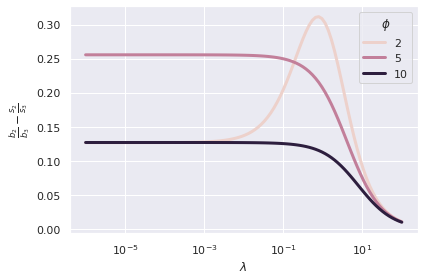

In [88]:
res = pd.DataFrame(res, columns=['phi', 'lam', 'val'])
fig, axes = plt.subplots(1,1,figsize=(6,4), sharex=True, sharey=True)
sns.lineplot(res, x='lam', hue='phi', y='val', lw=3, ax=axes)
axes.set_xscale('log')
axes.set_xlabel(r'$\lambda$')
axes.set_ylabel(r'$\frac{b_2}{b_3} - \frac{s_2}{s_3}$')
axes.legend(title=r'$\phi$')

fig.tight_layout()
plt.savefig('result/fig_alignment_cond.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Figure 1

Text(0, 0, '2')
Text(0, 0, '5')
Text(0, 0, '10')
Text(0, 0, 'Lower bound')
Text(0, 0, '$\\lambda_{\\mathrm{naive}}$')
Text(0, 0, '$\\lambda_{\\min}$')


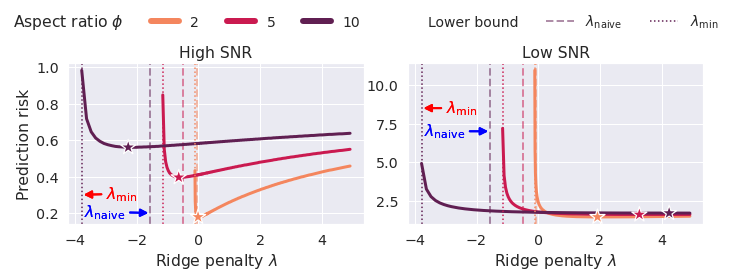

In [4]:
import matplotlib.lines as mlines
from generate_data import ar1_cov


sns.set(font_scale=1.3)

phi_list = [2,5,10]
palette = sns.color_palette("rocket_r", len(phi_list))
Sigma = ar1_cov(rho_ar1, 500)
r_min = np.linalg.eigh(Sigma)[0][0]
naive_lam_min = -(np.sqrt(phi_list) - 1)**2 * r_min



fig, axes = plt.subplots(1, 2, figsize=(10,4))
rho_ar1 = 0.5
locs = [
    [[0.2, 0.18], [0.3, 0.28]],
    [[7, 6.7], [8.5, 8.2]]
]
for i, sigma in enumerate([0.1, 1.]):

    path_result = 'result/ex1/{:.02f}_{:.02f}/'.format(rho_ar1, sigma)
    filename = path_result+'res_opt_ridge.pkl'
    _df = pd.read_pickle(filename, compression='gzip')
    _df.dropna(inplace=True)
    _df = _df[_df['lam']<=5]
    _df['phi'] = _df['phi'].astype(int)
    _df = _df.reset_index(drop=True)
    _df['risk'] = np.round(_df['risk'], 3)
    

    sns.lineplot(data=_df, x='lam', y='risk', hue='phi',        
        palette=palette, lw=3, ax=axes[i],)
    sns.scatterplot(data=_df.loc[_df.groupby('phi')['risk'].idxmin()], 
        x='lam', y='risk', hue='phi', marker='*', s=250, 
        edgecolor='w', zorder=5,
        palette=palette, ax=axes[i])
    for ilam, lam in enumerate(naive_lam_min):
        axes[i].axvline(x=lam, linestyle='--', color=palette[ilam], 
            alpha=0.5, lw=2, zorder=1, label='naive')

    lam_min = _df.loc[_df.groupby('phi')['lam'].idxmin()]['lam'].values
    for ilam, lam in enumerate(lam_min):
        axes[i].axvline(x=lam, linestyle=':', color=palette[ilam], 
            zorder=2, label='min')


    for i, loc in enumerate(locs):
        axes[i].annotate(r'$\lambda_{\mathrm{naive}}$', xy=(naive_lam_min[2], loc[0][0]),
            xycoords='data',
            xytext=(-3.7, loc[0][1]),
            textcoords='data', color='blue',
            arrowprops=dict(arrowstyle= '-|>',
                            color='blue',
                            lw=2,
                            ls='-')
                            )
        axes[i].annotate(r'$\lambda_{\min}$', xy=(lam_min[2], loc[1][0]),
            xycoords='data',
            xytext=(-3, loc[1][1]),
            textcoords='data', color='red',
            arrowprops=dict(arrowstyle= '-|>',
                            color='red',
                            lw=2,
                            ls='-')
                            )

axes[0].set_ylabel(r'Prediction risk')
axes[1].set_ylabel('')
for i in range(2):    
    axes[i].set_xlabel(r'Ridge penalty $\lambda$')
    

axes[0].set_title('High SNR')
axes[1].set_title('Low SNR')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

legend = fig.legend(title='Aspect ratio $\phi$', 
    handles=handles[:3] + [mlines.Line2D([], [], color='k', linestyle='None')] + handles[-4::3], 
    labels=phi_list + ['Lower bound', r'$\lambda_{\mathrm{naive}}$', r'$\lambda_{\min}$'], loc=2, ncol=10, frameon=False, fontsize=14)

legend_title_left(legend)
for i in range(2):
    axes[i].get_legend().remove()

for item, label in zip(legend.legendHandles, legend.texts):
    print(label)
    if label.get_text() in np.array(phi_list, dtype=str):
        item.set_linewidth(6)
    label.set_ha('left')

fig.tight_layout()
fig.subplots_adjust(top=0.78)
plt.savefig('result/fig_ridge_risk_lam.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Figure 2

/tmp/ipykernel_2060665/1062279525.py:25: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=_df, x='lam', y='risk', hue='type', style='type', style_order=['out','in',],
/tmp/ipykernel_2060665/1062279525.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data=_df.loc[_df.groupby(['type','phi'])['risk'].idxmin()],
/tmp/ipykernel_2060665/1062279525.py:25: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=_df, x='lam', y='risk', hue='type', style='type', style_order=['out','in',],
/tmp/ipykernel_2060665/1062279525.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data=_df.loc[_df.groupby(['type','phi'])['risk'].idxmin()],


['in', 'out', 'in', 'out']
Text(0, 0, 'in-distribution')
Text(0, 0, 'out-of-distribution')


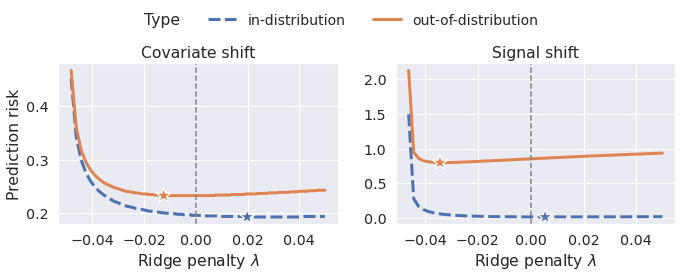

In [51]:
import matplotlib.lines as mlines
from generate_data import ar1_cov


sns.set(font_scale=1.3)

phi_list = [1.5,2.,3,4]
palette = sns.color_palette()
sigma = 0.1


fig, axes = plt.subplots(1, 2, figsize=(10,4))
for i, shift in enumerate(['cov','sig']):
    rho_ar1 = 0.5 if shift=='sig' else 0.
    path_result = 'result/ex1/{:.02f}_{:.02f}/'.format(rho_ar1, sigma)
    filename = path_result+'res_opt_ridge_{}.pkl'.format(shift)
    _df = pd.read_pickle(filename, compression='gzip')
    _df.dropna(inplace=True)
    _df = _df[_df['lam']<=0.05]
    _df = pd.wide_to_long(_df, stubnames='risk', sep='_', suffix=r'\w+', i=['phi', 'lam'], j='type').reset_index()
    _df['risk'] = np.round(_df['risk'], 3)
    
    _df = _df[_df['phi']<1.7]
    sns.lineplot(data=_df, x='lam', y='risk', hue='type', style='type', style_order=['out','in',],
        palette=palette, lw=3, ax=axes[i],)
    sns.scatterplot(data=_df.loc[_df.groupby(['type','phi'])['risk'].idxmin()], 
        x='lam', y='risk', hue='type', marker='*', s=250, 
        edgecolor='w', zorder=5,
        palette=palette, ax=axes[i])
    
# axes[0].set_xscale('symlog')

axes[0].set_ylabel(r'Prediction risk')
axes[1].set_ylabel('')
for i in range(2):    
    axes[i].set_xlabel(r'Ridge penalty $\lambda$')
    axes[i].axvline(0, ls='--', color='gray')
    

axes[0].set_title('Covariate shift')
axes[1].set_title('Signal shift')

               
for i in range(2):
    lines_labels = [ax.get_legend_handles_labels() for ax in [axes[i]]]
    handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    axes[i].legend(
        title='Aspect ratio $\phi$', handles=handles[:3], labels=phi_list,
        loc='upper right')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
legend = fig.legend(title='Type', 
    handles = handles[:2], labels =['in-distribution', 'out-of-distribution'],
    loc=9, ncol=10, frameon=False, fontsize=14)

legend_title_left(legend)
for i in range(2):
    axes[i].get_legend().remove()

for item, label in zip(legend.legendHandles, legend.texts):
    print(label)
    if label.get_text() in np.array(phi_list, dtype=str):
        item.set_linewidth(6)
    label.set_ha('left')

fig.tight_layout()
fig.subplots_adjust(top=0.78)
plt.savefig('result/fig_ridge_risk_lam_shift.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Real data Figure F7

In [5]:
path_result = 'result/ex2/'

lams = np.arange(-100, 100)
filename = path_result+'res_out.pkl'

with open(filename, 'rb') as f:
    mse_out = np.load(f)

filename = path_result+'res_mineig.pkl'
mineig = pd.read_pickle(filename, compression='gzip').iloc[:,0].values

df = pd.DataFrame(np.mean(mse_out[:, mineig>100], axis=1), index=lams, 
    columns=['risk-'+str(i) for i in range(mse_out.shape[-1])])
df['lam'] = lams
print(np.sum(mineig<100))

df = pd.wide_to_long(df, stubnames='risk', sep='-', 
    suffix=r'\w+', 
    i='lam', j='type'
    )


filename = path_result+'res_out_per_class.pkl'
with open(filename, 'rb') as f:
    mse_out_per_class = np.load(f)

df_per_class = pd.DataFrame(np.mean(mse_out_per_class[:, mineig>100], axis=1), index=lams, 
    columns=['risk-'+str(i) for i in range(mse_out_per_class.shape[-1])])
df_per_class['lam'] = lams
df_per_class = pd.wide_to_long(df_per_class, stubnames='risk', sep='-', 
    suffix=r'\w+', i='lam', j='class'
    )

df_per_class = df_per_class.reset_index()

3


In [ ]:
df.loc[df.groupby('type')['risk'].idxmin()].round(2)

,,risk
lam,type,
1.031250,0,7.68
0.484375,1,8.41
0.000000,2,9.13
-0.484375,3,9.47
1.437500,4,10.18


/tmp/ipykernel_907956/690482470.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(data=df, x='lam', y='risk', hue='type', style='type', #style_order=['out','in',],
/tmp/ipykernel_907956/690482470.py:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=df.loc[df.groupby(['type'])['risk'].idxmin()],


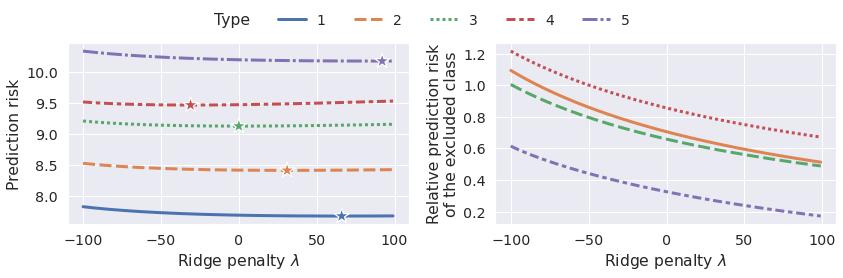

In [ ]:
sns.set(font_scale=1.3)

palette = sns.color_palette()
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(data=df, x='lam', y='risk', hue='type', style='type',
    palette=palette, lw=3, ax=axes[0])
sns.scatterplot(data=df.loc[df.groupby(['type'])['risk'].idxmin()], 
    x='lam', y='risk', hue='type', marker='*', s=250, 
    edgecolor='w', zorder=5, legend=False,
    palette=palette, ax=axes[0])


sns.lineplot(df_per_class[df_per_class['class'].isin([1,2,3,4])], x='lam', y='risk', 
             hue='class', style='class', lw=3,
             palette=sns.color_palette()[1:5], 
             hue_order=[4,3,2,1], style_order=[4,3,2,1], ax=axes[1])

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = np.arange(1,6).astype(str).tolist()

for j in range(2):
    axes[j].get_legend().remove()
legend = fig.legend(
    title='Type', handles=handles, labels=labels,
    loc=9, ncol=10, frameon=False, fontsize=14)


axes[0].set_ylabel(r'Prediction risk')
axes[1].set_ylabel('Relative prediction risk\nof the excluded class')
for j in range(2):
    axes[j].set_xlabel(r'Ridge penalty $\lambda$')
    
legend_title_left(legend)


fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_mnist.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
path_result = 'result/ex3/'
lams = np.arange(-100, 100)

df_res = pd.DataFrame()
for n in np.arange(25,225,25):
    
    filename = path_result+'res_out_{}.pkl'.format(n)

    with open(filename, 'rb') as f:
        mse_out = np.load(f)

    filename = path_result+'res_mineig_{}.pkl'.format(n)
    mineig = pd.read_pickle(filename, compression='gzip').iloc[:,0].values

    df = pd.DataFrame(np.mean(mse_out[:, mineig>100], axis=1), index=lams, 
        columns=['risk-'+str(i) for i in range(mse_out.shape[-1])])
    df['lam'] = lams
    print(np.sum(mineig<100))

    df = pd.wide_to_long(df, stubnames='risk', sep='-', 
        suffix=r'\w+', 
        i='lam', j='type'
        ).reset_index()
#     df = df[df['lam']>=0.]
    df = df.loc[df.groupby(['type'])['risk'].idxmin()].reset_index()
    df['n'] = n

    df_res = pd.concat([df_res, df], axis=0)

1
3
5
6
11
23
32
48


/tmp/ipykernel_907956/2693299415.py:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(df_res, x='n', y='risk', hue='type',


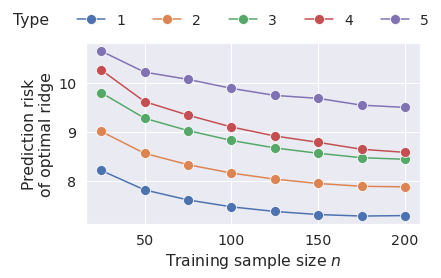

In [ ]:
sns.set(font_scale=1.3)

palette = sns.color_palette()

fig, ax = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df_res, x='n', y='risk', hue='type', 
             palette=palette, marker='.', markersize=20, ax=ax)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = np.arange(1,6).astype(str).tolist()
ax.get_legend().remove()
legend = fig.legend(
    title='Type', handles=handles, labels=labels,
    loc=9, ncol=10, frameon=False, fontsize=14)
ax.set_xlabel(r'Training sample size $n$')
ax.set_ylabel('Prediction risk\nof optimal ridge')

legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_mnist_mono.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Figure 3

/tmp/ipykernel_1811349/918734787.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticks(), rotation=0, fontsize=16)
/tmp/ipykernel_1811349/918734787.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(np.round(axes[1].get_yticks(), 1), fontsize=16)


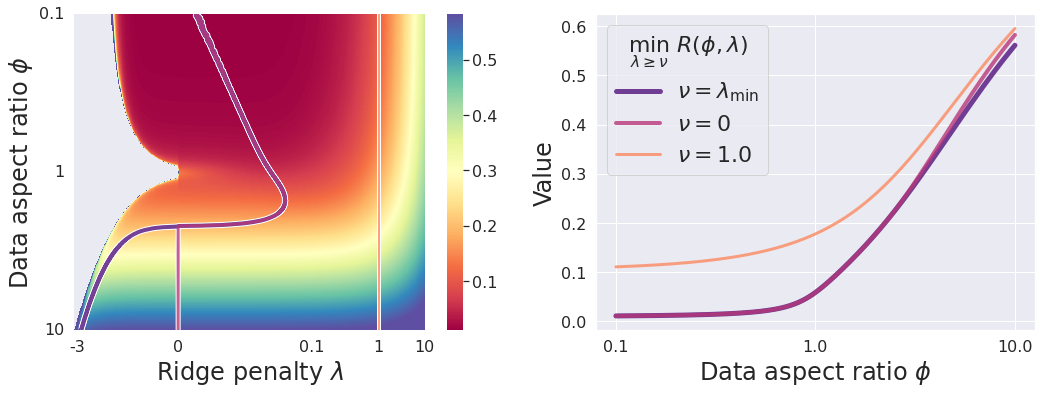

In [9]:
sigma = .1
rho_ar1 = 0.5

path_result = 'result/ex3/{:.02f}_{:.02f}/'.format(rho_ar1, sigma)
filename = path_result+'res_mono.pkl'
_df = pd.read_pickle(filename, compression='gzip')
_df.dropna(inplace=True)
_df = _df[_df['lam']<=5]
_df = _df.reset_index(drop=True)
_df['risk'] = np.round(_df['risk'], 7)

_df = _df.pivot(index="phi", columns="lam", values='risk').T


fig, axes = plt.subplots(1, 2, figsize=(15,6))
cmap = sns.color_palette("Spectral", as_cmap=True)
sns.set(font_scale=2.)

vmax=np.nanquantile(_df.values, 0.99)
vmin=np.nanquantile(_df.values, 0.001)
vmin = np.nanmin(_df.values)

sns.heatmap(_df, cmap=cmap, ax=axes[0], vmin=vmin, vmax=vmax, rasterized=True)

colors = sns.color_palette("magma", 3)
for i, lam_min in enumerate([-np.inf,0,1.]):
    id_col = _df.iloc[_df.index>=lam_min,:].apply(np.nanargmin, axis=0).values + np.sum(_df.index<lam_min)
    idx = np.arange(_df.shape[1])
    axes[0].plot(idx, id_col, dashes=[1., 0], 
            c='white', linewidth=4-i+2, alpha=1., zorder=2)
    axes[0].plot(idx, id_col, dashes=[1., 0], 
            c=colors[i], linewidth=3-i+1, alpha=.8, zorder=3)
    
    axes[1].plot(_df.columns, _df.values[id_col, idx], c=colors[i], alpha=.8,
                 lw=4-i+1, label=r'$\nu={}$'.format(
                     '\lambda_{{\min}}' if i==0 else lam_min))
    
axes[1].set_xscale('log')
legend = axes[1].legend(title=r'$\min_{\lambda\geq \nu}\ R(\phi,\lambda)$')
legend.get_title().set_fontsize('22')
axes[0].set_xlabel('Data aspect ratio $\phi$')
axes[0].set_ylabel('Ridge penalty $\lambda$')

axes[1].set_xlabel('Data aspect ratio $\phi$')
axes[1].set_ylabel('Value')

phis = [0.1, 1., 10.]
ticks = [np.argmin(np.abs(_df.columns-phi)) for phi in phis]
axes[0].set_xticks(ticks)
axes[0].set_xticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in phis ], rotation=0, fontsize=16)

lams = [-3, 0, 0.1, 1., 10.]
ticks = [np.argmin(np.abs(_df.index-lam)) for lam in lams]
axes[0].set_yticks(ticks)
axes[0].set_yticklabels([ f"{x:.01f}" if 0<x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
axes[0].figure.axes[-1].tick_params(labelsize=16)


axes[1].set_xticklabels(axes[1].get_xticks(), rotation=0, fontsize=16)
axes[1].set_yticklabels(np.round(axes[1].get_yticks(), 1), fontsize=16)

fig.tight_layout()
plt.savefig('result/fig_mono.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

/tmp/ipykernel_1811349/918734787.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticks(), rotation=0, fontsize=16)
/tmp/ipykernel_1811349/918734787.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(np.round(axes[1].get_yticks(), 1), fontsize=16)


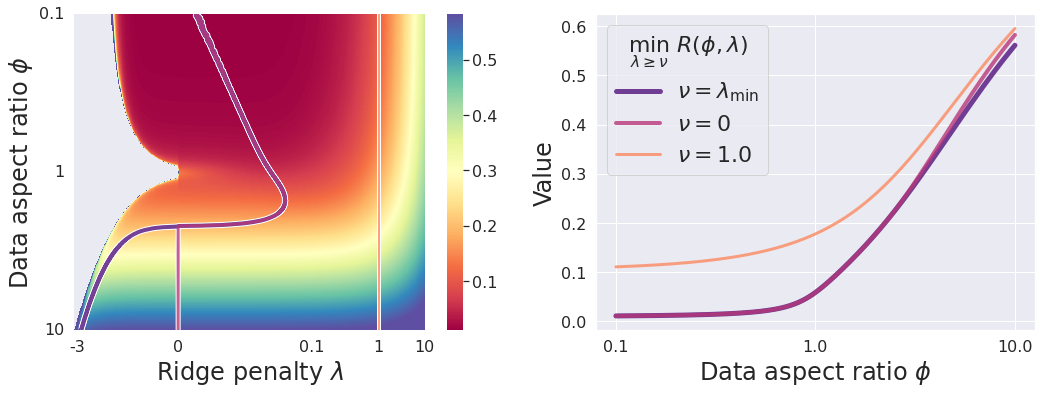

In [10]:
sigma = .1
rho_ar1 = 0.5

path_result = 'result/ex3/{:.02f}_{:.02f}/'.format(rho_ar1, sigma)
filename = path_result+'res_mono.pkl'
_df = pd.read_pickle(filename, compression='gzip')
_df.dropna(inplace=True)
_df = _df[_df['lam']<=5]
_df = _df.reset_index(drop=True)
_df['risk'] = np.round(_df['risk'], 7)

_df = _df.pivot(index="phi", columns="lam", values='risk')

fig, axes = plt.subplots(1, 2, figsize=(15,6))
cmap = sns.color_palette("Spectral", as_cmap=True)
sns.set(font_scale=2.)

vmax=np.nanquantile(_df.values, 0.99)
vmin=np.nanquantile(_df.values, 0.001)
vmin = np.nanmin(_df.values)


sns.heatmap(_df, cmap=cmap, ax=axes[0], vmin=vmin, vmax=vmax, rasterized=True)

colors = sns.color_palette("magma", 3)
for i, lam_min in enumerate([-np.inf,0,1.]):
    id_row = _df.iloc[:,_df.columns>=lam_min].apply(np.nanargmin, axis=1).values + np.sum(_df.columns<lam_min)
    idx = np.arange(_df.shape[0])
    axes[0].plot(id_row, idx, dashes=[1., 0], 
            c='white', linewidth=4-i+2, alpha=1., zorder=2)
    axes[0].plot(id_row, idx, dashes=[1., 0], 
            c=colors[i], linewidth=3-i+1, alpha=.8, zorder=3)
    
    axes[1].plot(_df.index, _df.values[idx, id_row],  c=colors[i], alpha=.8,
                 lw=4-i+1, label=r'$\nu={}$'.format(
                     '\lambda_{{\min}}' if i==0 else lam_min))
    
axes[1].set_xscale('log')
legend = axes[1].legend(title=r'$\min_{\lambda\geq \nu}\ R(\phi,\lambda)$')
legend.get_title().set_fontsize('22')
axes[0].set_xlabel('Ridge penalty $\lambda$')
axes[0].set_ylabel('Data aspect ratio $\phi$')

axes[1].set_xlabel('Data aspect ratio $\phi$')
axes[1].set_ylabel('Value')

phis = [0.1, 1., 10.]
ticks = [np.argmin(np.abs(_df.index-phi)) for phi in phis]
axes[0].set_yticks(ticks)
axes[0].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in phis ], fontsize=16)

lams = [-3, 0, 0.1, 1., 10.]
ticks = [np.argmin(np.abs(_df.columns-lam)) for lam in lams]
axes[0].set_xticks(ticks)
axes[0].set_xticklabels([ f"{x:.01f}" if 0<x<1 else f"{x:.0f}" for x in lams ], rotation=0, fontsize=16)
axes[0].figure.axes[-1].tick_params(labelsize=16)


axes[1].set_xticklabels(axes[1].get_xticks(), rotation=0, fontsize=16)
axes[1].set_yticklabels(np.round(axes[1].get_yticks(), 1), fontsize=16)

fig.tight_layout()
plt.savefig('result/fig_mono.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Figure 4

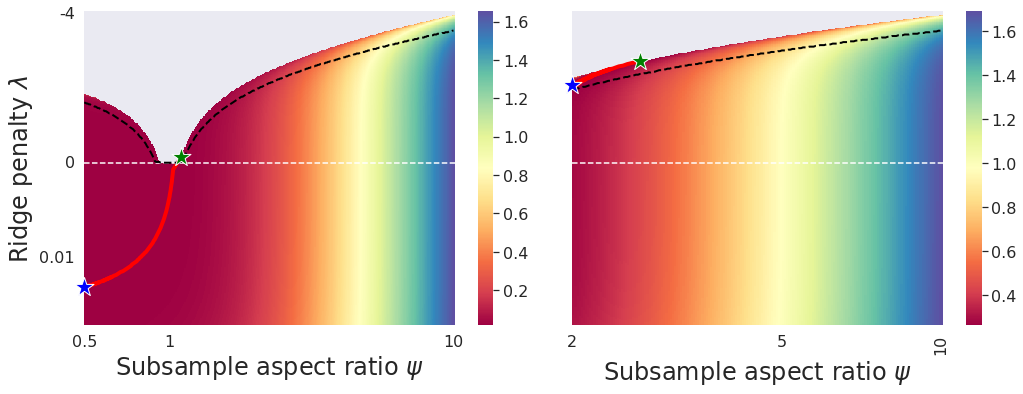

In [3]:
rho_ar1 = 0.5
sigma = 0.1

from generate_data import ar1_cov
Sigma = ar1_cov(rho_ar1, 500)
r_min = np.linalg.eigh(Sigma)[0][0]

cmap = sns.color_palette("Spectral", as_cmap=True)
fig, axes = plt.subplots(1,2,figsize=(15,6), sharey=True)
sns.set(font_scale=2.)
for i, phi in enumerate([0.5,2]):
    path_result = 'result/ex4/{:.02f}_{:.02f}_{:.02f}/'.format(phi, rho_ar1, sigma)
    filename = path_result+'res_equiv_risk.pkl'
    _df = pd.read_pickle(filename, compression='gzip')

    if i==0:
        _df['risk'] = np.round(_df['risk'], 7)
    else:
        _df['risk'] = np.round(_df['risk'], 3)
    _df = _df[_df['lam']<=0.05]
    _df = _df.pivot(index="psi", columns="lam", values='risk').T

    vmax = np.nanmax(_df.values)
    vmin = np.nanmin(_df.values)

    sns.heatmap(_df, cmap=cmap, ax=axes[i],
                vmin=vmin, vmax=vmax, rasterized=True
            )

    id_psi = np.where(_df.values == np.min(_df))[1]
    id_lam = np.where(_df.values == np.min(_df))[0]

    axes[i].plot(id_psi, id_lam, dashes=[1., 0], c='red', linewidth=4)

    axes[i].scatter(id_psi[np.argmin(id_lam)], np.min(id_lam), color='green', s=400, 
               marker='*', edgecolor='white',clip_on=False, zorder=5)
    axes[i].scatter(np.min(id_psi), id_lam[np.argmin(id_psi)], color='blue', s=400, 
               marker='*', edgecolor='white',clip_on=False, zorder=5)


    id_lam = np.where(_df.index == 0.)[0][0]
    axes[i].axhline(id_lam, ls='--', c='white')


    naive_lam_min = -(np.sqrt(_df.columns) - 1)**2 * r_min
    id_lam_naive = [np.argmin((_df.index - lam)**2) for lam in naive_lam_min]

    axes[i].plot(np.arange(len(id_lam_naive)), id_lam_naive, '--', color='black', lw=2, clip_on=False)   

    if i ==0:        
        axes[i].set_ylabel('Ridge penalty $\lambda$')        
    else:
        axes[i].set_ylabel('')
    axes[i].set_xlabel('Subsample aspect ratio $\psi$')

    n_grid = len(_df.columns)
    ticks = np.append(np.arange(0,n_grid,200), n_grid-1)
    lams = np.array(_df.columns)[ticks]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], rotation=0, fontsize=16)

    n_grid=len(_df.index)
    ticks = np.append(np.arange(0,n_grid,200), n_grid-1)
    lams = np.array(_df.index)[ticks]
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=16)

    if i==0:
        lams = [-4, 0, 0.01]
    else:
        lams = [-4, 0, 0.01]
    ticks = [np.argmin(np.abs(_df.index-lam)) for lam in lams]
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.02f}" if 0<x<1 else f"{x:.0f}" for x in lams ], rotation=0, fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=16)

    if i==0:
        psis = [0.5, 1., 10.]
    else:
        psis = [2., 5., 10.]
    ticks = [np.argmin(np.abs(_df.columns-phi)) for phi in psis]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in psis ], fontsize=16)

    
fig.tight_layout()
plt.savefig('result/fig_ridge_ensemble_risk.pdf', bbox_inches='tight', pad_inches=0, dpi=300)